<a href="https://colab.research.google.com/github/dogukartal/ML-RoadMap/blob/main/NLP/Hugging%20Face/PyTorch/Decoding_Strategies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [64]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilgpt2")
inputs = tokenizer("I enjoy walking with my cute dog", return_tensors="pt")

model = AutoModelForCausalLM.from_pretrained("distilbert/distilgpt2")
model.generation_config

GenerationConfig {
  "bos_token_id": 50256,
  "eos_token_id": 50256
}

A decoding strategy for a model is defined in its generation configuration.
### Greedy Search
---
The default decoding strategy is **greedy search**, which is the simplest decoding strategy that picks a token with the highest probability as the next token. For many tasks and small output sizes this works well. However, when used to generate longer outputs, greedy search can start producing **highly repetitive** results.

In [65]:
greedy_output = model.generate(
    **inputs,
    max_new_tokens=40
)
tokenizer.decode(greedy_output[0], skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'I enjoy walking with my cute dog. I love it. I love it. I love it. I love it. I love it. I love it. I love it. I love it. I love it. I love it'

### Beam Search
---
Beam search reduces the risk of missing hidden high probability word sequences by keeping the most likely num_beams of hypotheses at each time step and eventually choosing the hypothesis that has the overall highest probability.

In [67]:
beam_output = model.generate(
    **inputs,
    max_new_tokens=40,
    num_beams=5,
    early_stopping=True,
)
tokenizer.decode(beam_output[0], skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'I enjoy walking with my cute dog.”\n\n”\n”\n”\n”\n”\n”'

While the result is arguably more fluent, the output still includes repetitions of the same word sequences. One of the available remedies is to introduce n-grams (a.k.a word sequences of n words) penalties. The most common n-grams penalty makes sure that no n-gram appears twice by manually setting the probability of next words that could create an already seen n-gram to 0.

In [68]:
beam_output = model.generate(
    **inputs,
    max_new_tokens=40,
    num_beams=5,
    no_repeat_ngram_size=2,
    early_stopping=True
)

print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog.”

“I’m so happy to be able to share this with you. I love you so much, and I want to thank you all for your support.



Another important feature about beam search is that we can compare the top beams after generation and choose the generated beam that fits our purpose best. In transformers, we simply set the parameter num_return_sequences to the number of highest scoring beams that should be returned.

In [69]:
beam_outputs = model.generate(
    **inputs,
    max_new_tokens=40,
    num_beams=5,
    no_repeat_ngram_size=2,
    num_return_sequences=5,
    early_stopping=True
)

for i, beam_output in enumerate(beam_outputs):
  print("{}: {}".format(i, tokenizer.decode(beam_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: I enjoy walking with my cute dog.”

“I’m so happy to be able to share this with you. I love you so much, and I want to thank you all for your support.

1: I enjoy walking with my cute dog.”

“I’m so happy to be able to share this with you. I love you so much, and I want to thank you all for your support. Thank
2: I enjoy walking with my cute dog.”

“I’m so happy to be able to share this with you. I love you so much, and I want to thank you all for your support and support
3: I enjoy walking with my cute dog.”
4: I enjoy walking with my cute dog.”

“I’m so happy to be able to share this with you. I love you so much, and I want to thank you all for your support and encouragement


- Beam search can work very well in tasks where the length of the desired generation is more or less predictable as in machine translation or summarization. But this is not the case for open-ended generation where the desired output length can vary greatly, e.g. dialog and story generation.
- We have seen that beam search heavily suffers from repetitive generation. This is especially hard to control with *n-gram*- or other penalties in story generation since finding a good trade-off between inhibiting repetition and repeating cycles of identical *n-grams* requires a lot of fine-tuning.
- High quality human language does not follow a distribution of high probability next words. In other words, as humans, we want generated text to surprise us and not to be boring/predictable.

### Multinomial Sampling
---
In its most basic form, sampling means randomly picking the next word according to its conditional probability distribution. In transformers, we set do_sample=True and deactivate Top-K sampling (more on this later) via top_k=0.

In [70]:
sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k=0
)

print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, LeRoy. While my pet le roaa took me to Cloudbase in 2016, they were dead.

I heard about other concern raised by my family! They are definitely not naive about


The problem with sampling word sequences is that the models often generate incoherent gibberish, not very coherent and doesn't sound like it was written by a human. One way to prevent is to sharpen the distribution by lovering the temperature of the softmax.

In [72]:
sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k=0,
    temperature=0.6,
)

print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog, I love it! I love how she treats it. She's a lovely one (and I'm sure she will love it). It's hard to keep up with her schedule and I enjoy the


### Top-K Sampling
---
In Top-K sampling, the K most likely next words are filtered and the probability mass is redistributed among only those K next words.

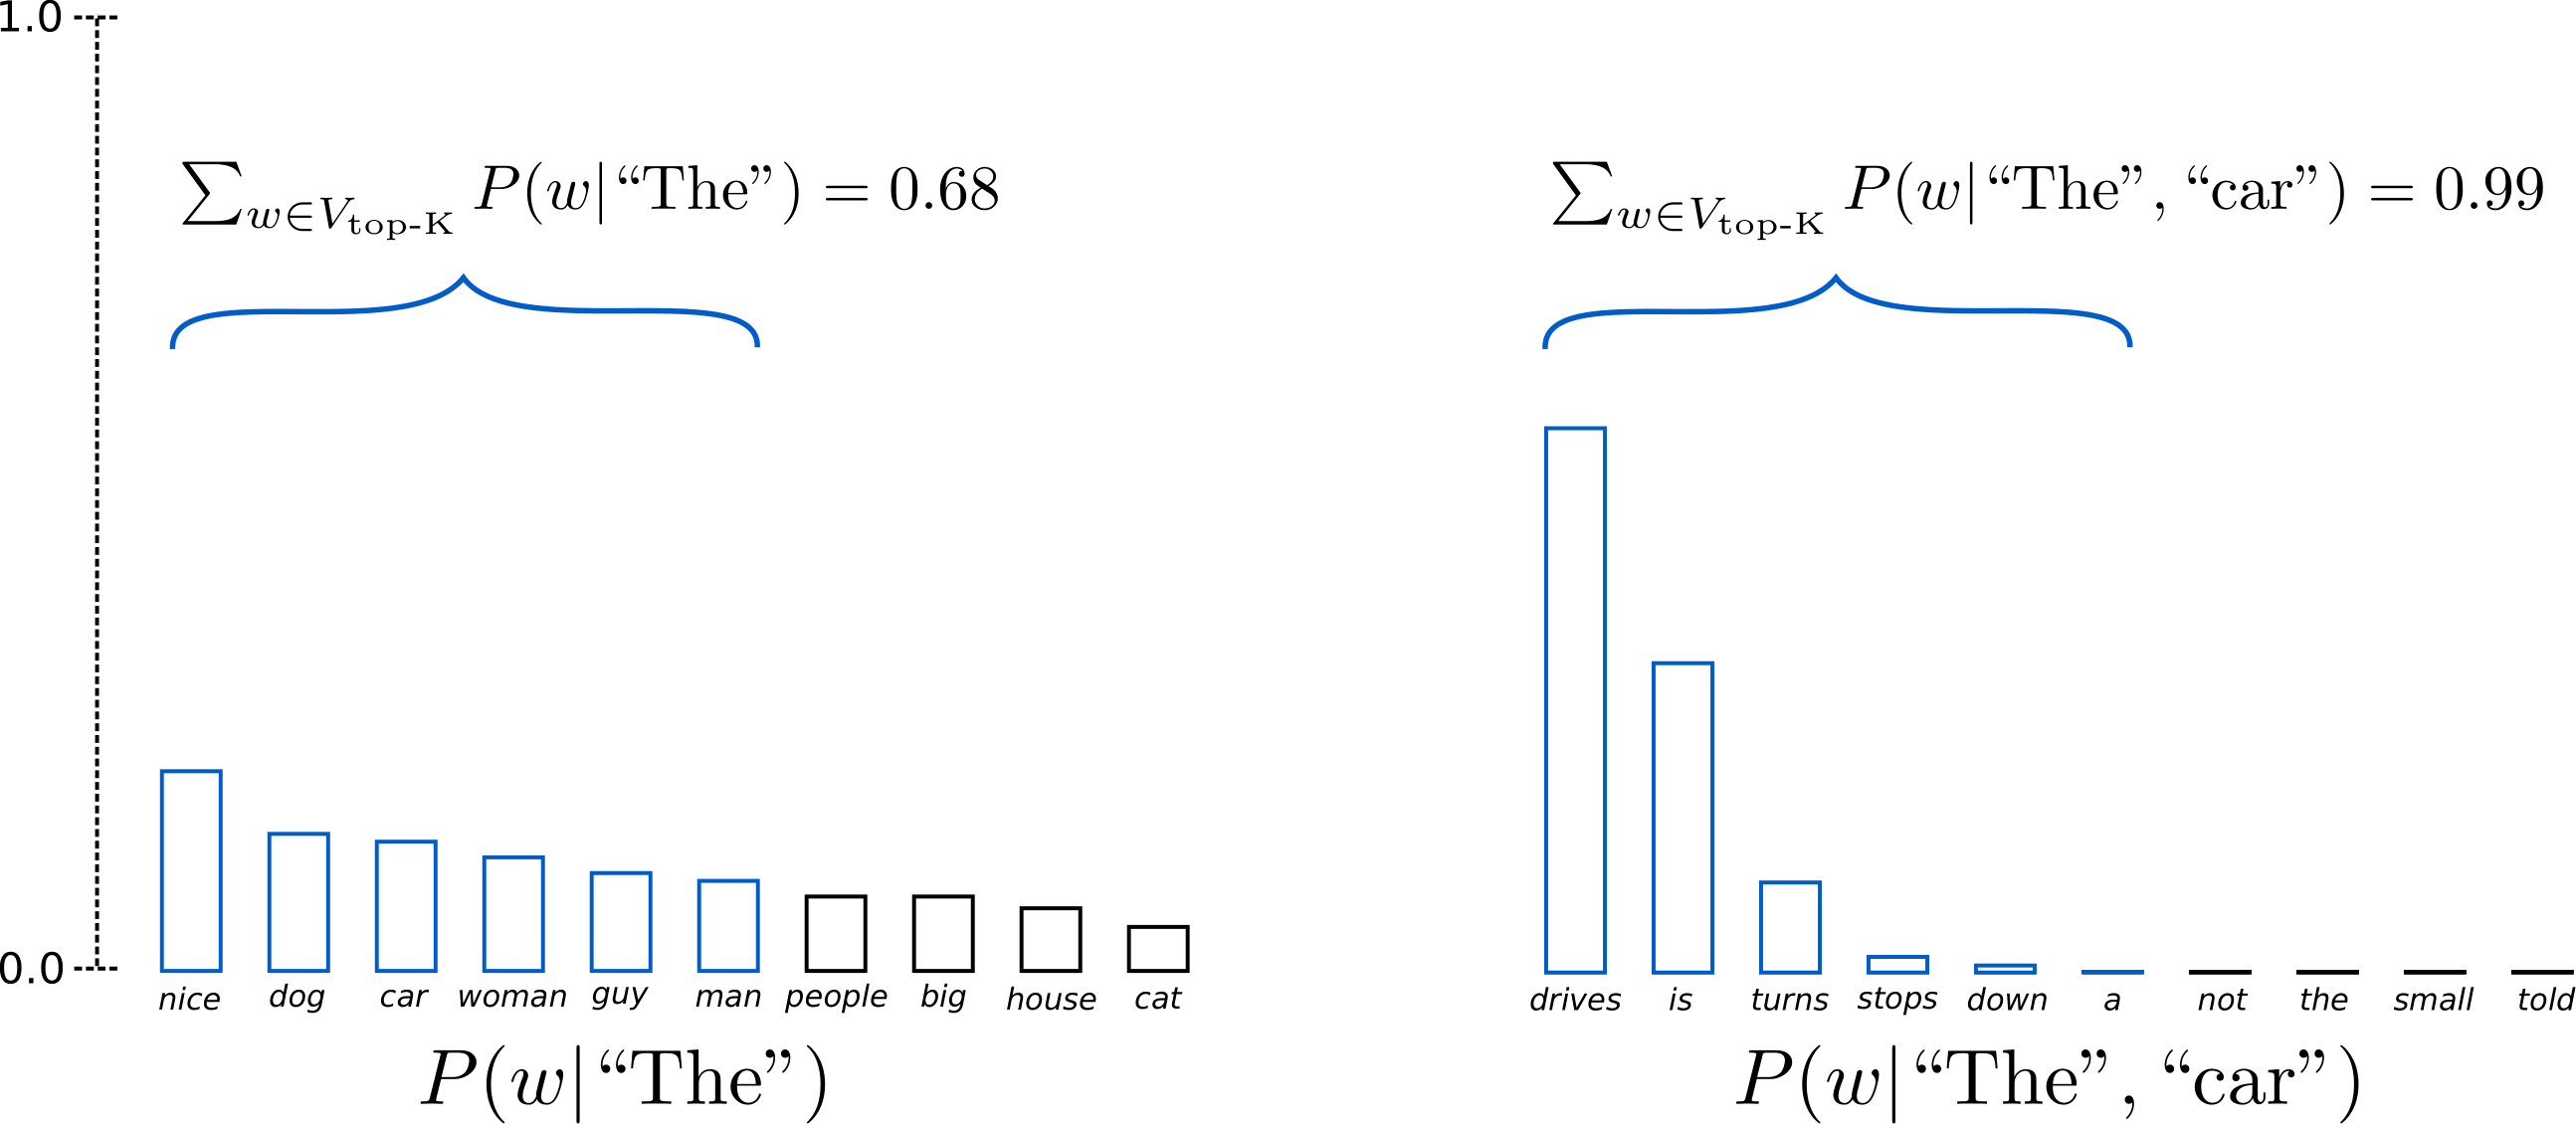

In [73]:
sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_k=50
)

print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog and I'm really stoked. I've never been to a dog before so it makes sense to try it on my own but this is definitely my first experience with a dog. I couldn't say more


### Top-p (Nucleus) Sampling
---
Instead of sampling only from the most likely K words, in Top-p sampling chooses from the smallest possible set of words whose cumulative probability exceeds the probability p. The probability mass is then redistributed among this set of words.

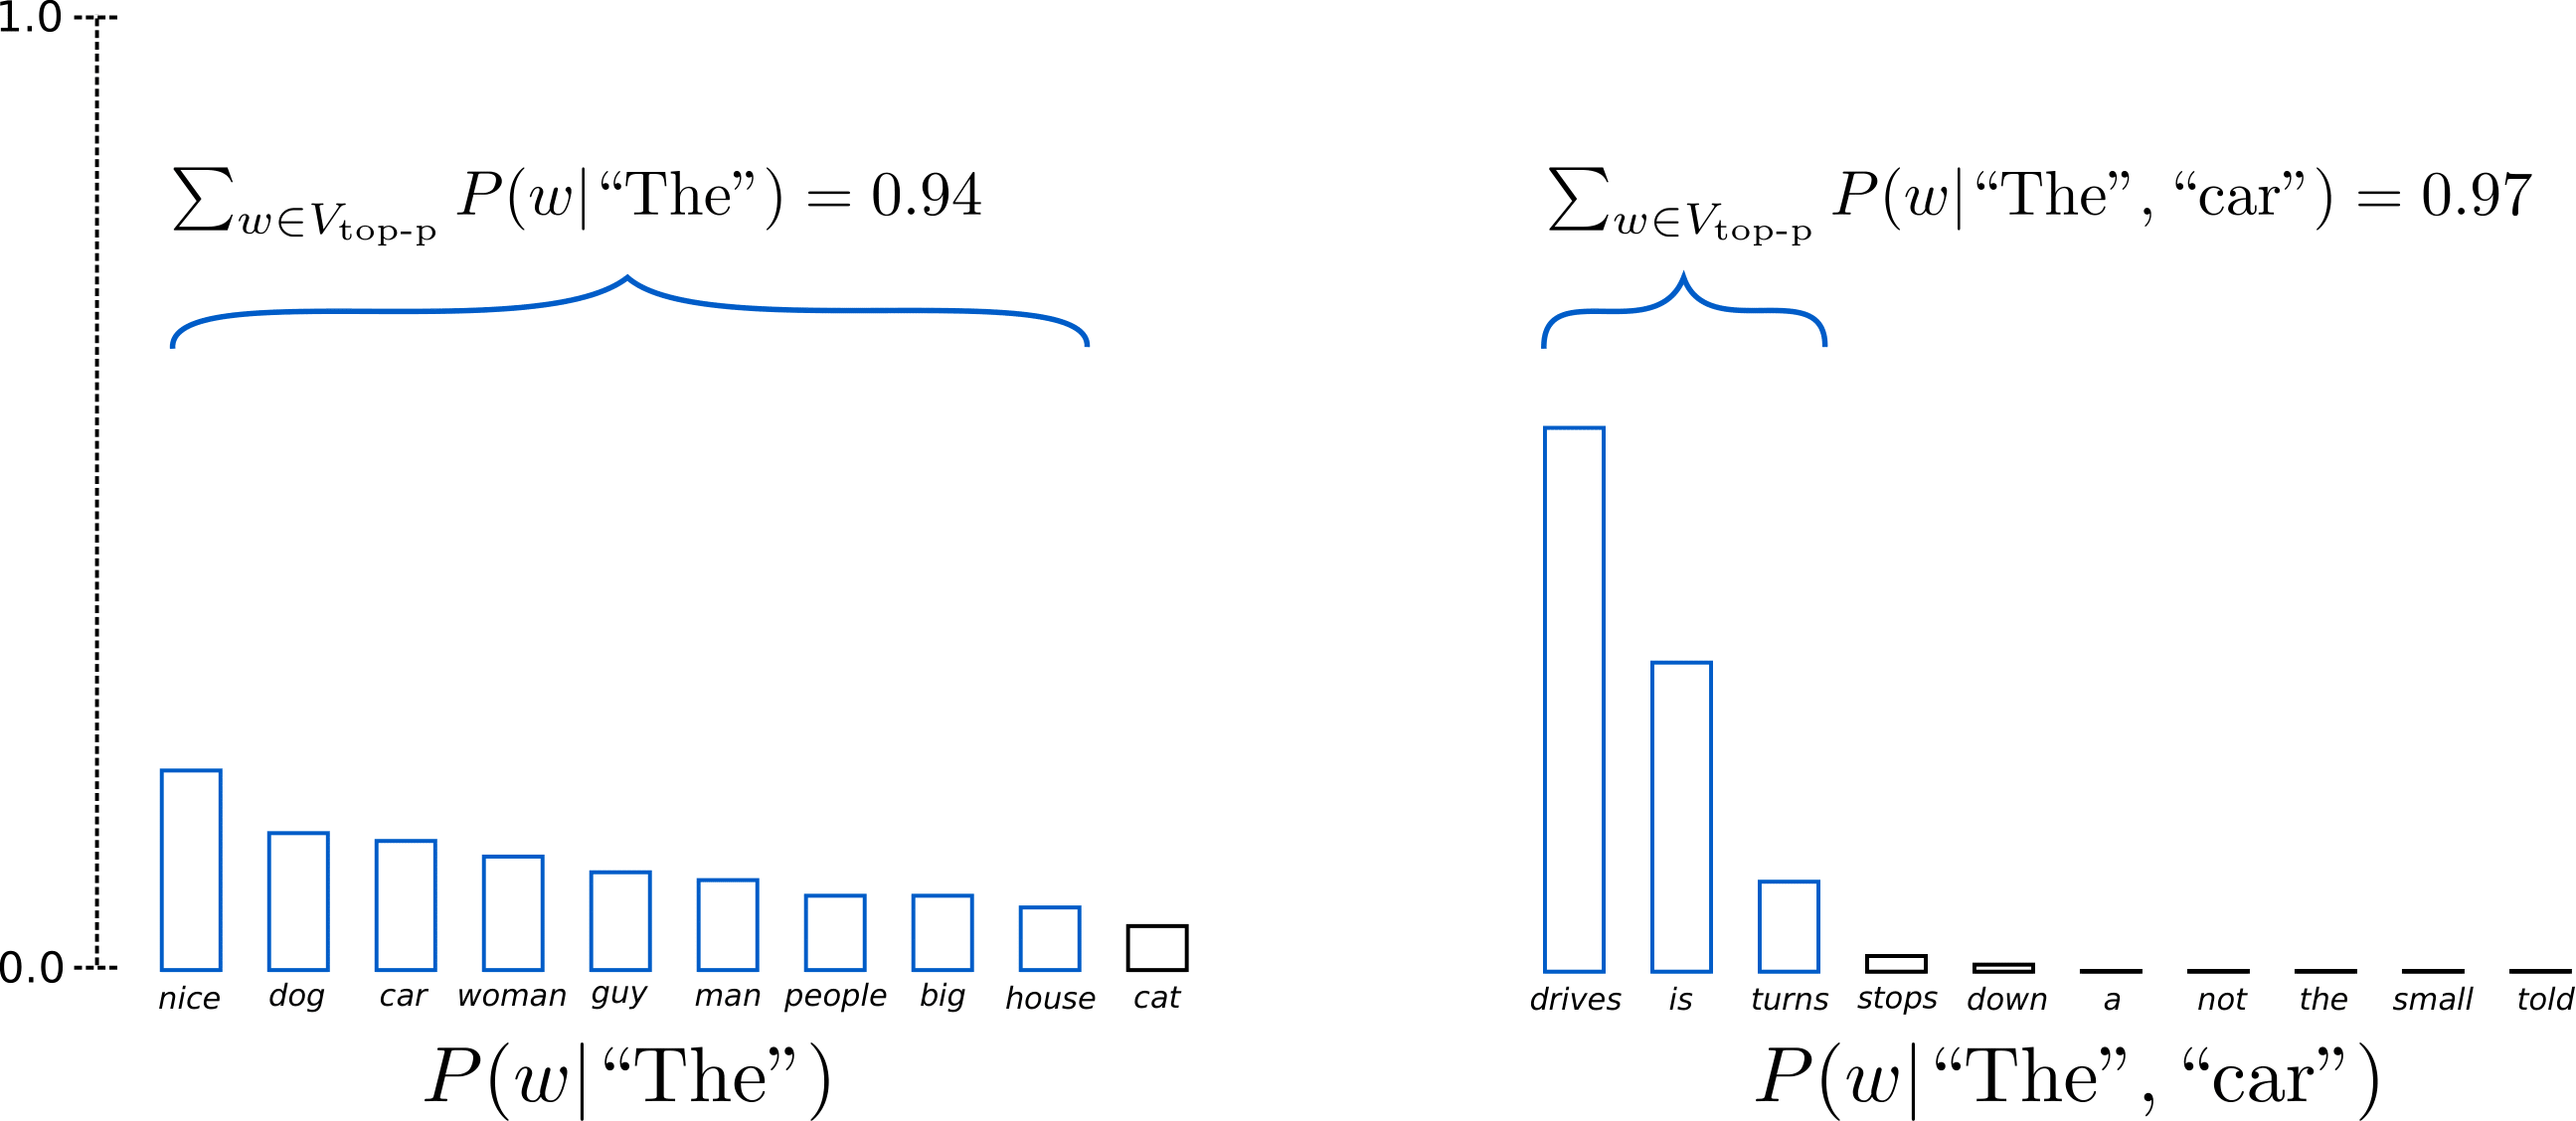

In [77]:
sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_p=0.92,
    top_k=0
)

print(tokenizer.decode(sample_output[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I enjoy walking with my cute dog on a leash, laughing at us on the park with our small dogs. To enjoy more than they could possibly have imagined, join me on Instagram or tweet it or send me any photos.




 Top-p can also be used in combination with Top-K, which can avoid very low ranked words while allowing for some dynamic selection.

In [79]:
sample_output = model.generate(
    **inputs,
    max_new_tokens=40,
    do_sample=True,
    top_p=0.92,
    top_k=50,
    num_return_sequences=3
)

for i, sample_output in enumerate(sample_output):
  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: I enjoy walking with my cute dog to play with."


"Your dog's cute, cute. He's going to play with you."
"You were nice and cute to me. Your mother had always liked you and
1: I enjoy walking with my cute dog.
So what makes a dog so unique is that you can enjoy the sounds and features you've always had in a dog. This may sound like a simple, simple concept, but when you realize
2: I enjoy walking with my cute dog and her amazing dog, so we could take advantage of the fact she is just so happy and loving!! The only complaint I can find at home about her are the "hear" noises (even


### Contrastive Search
---
Contrastive Search is a decoding strategy used in text generation to balance fluency and diversity. It aims to prevent the model from generating repetitive, uninformative, or low-quality text by searching for tokens that best contrast with previous tokens, ensuring that the sequence is both coherent and novel. The two main parameters that enable and control the behavior of contrastive search are penalty_alpha and top_k.

- $x_t$ :  This is the word (or token) being selected at time step t during the text generation process. It's the next word that will be added to the sequence being constructed.
- $v∈V^{(k)}$: The set of candidate words is restricted to the top k words based on their probabilities as determined by the model. Essentially, the search is conducted within a limited set of probable words.
- **α**: A balancing parameter (0 ≤  α ≤ 1) that controls the trade-off between confidence in the model and avoiding repetition.
- $p_θ​(v∣x_{<t}​)$:  The model's predicted probability of selecting word v given the sequence generated so far, ${x}_{<t}$. This term represents the model’s confidence in how likely a word is to follow the existing sequence.
- Degeneration Penalty: This part represents the **degeneration penalty** that discourages repetition and encourages diversity.

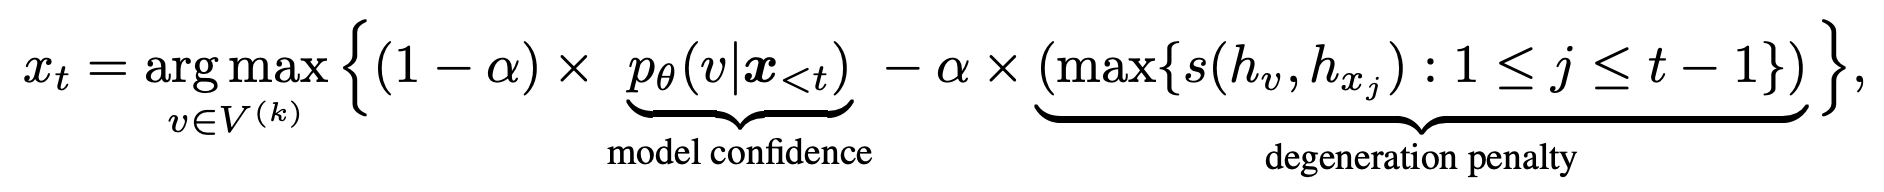

In [85]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

model_name = "gpt2-large"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, pad_token_id=tokenizer.eos_token_id).to("cuda")
model.eval()

prefix_text = r"Google is"
input_ids = tokenizer(prefix_text, return_tensors="pt").input_ids.to("cuda")

output = model.generate(input_ids, penalty_alpha=0.6, top_k=4, max_length=512)
print(tokenizer.decode(output[0], skip_special_tokens=True))

Google is working on a feature that would allow users to share photos and videos with their friends.

In an interview with TechCrunch, Google CEO Sundar Pichai said the company is "very excited about this," and that "we'll have more to share in the near future."

Pichai also revealed that Google has begun testing an Android-based version of Facebook's photo sharing app, Picasa, which is similar to the iPhone's iPhoto. Picasa, which launched in 2010, has more than 1.5 million users, according to Google.

"It's a great example of how the Internet of Things is going to change the way we interact with each other," Pichai said. "I think it's going to be an incredibly powerful tool for people, not just in the consumer space, but in the enterprise space as well."

Facebook's Photos app was the first to offer a way to share photos on the iPhone and iPod touch, but it's not the only one. Apple has been experimenting with similar features for a while, and Google has a long history of making apps

### Speculative (Assisted) Decoding
---
Speculative decoding uses an assistant model (ideally a much smaller one) with the same tokenizer, to generate a few candidate tokens. The main model then validates the candidate tokens in a single forward pass, which speeds up 10 times the decoding process.

In [87]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

prompt = "Alice and Bob"
checkpoint = "EleutherAI/pythia-1.4b-deduped"
assistant_checkpoint = "EleutherAI/pythia-160m-deduped"
device = "cuda"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
inputs = tokenizer(prompt, return_tensors="pt").to(device)

model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
assistant_model = AutoModelForCausalLM.from_pretrained(assistant_checkpoint).to(device)

outputs = model.generate(**inputs, assistant_model=assistant_model)
print(tokenizer.batch_decode(outputs, skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


['Alice and Bob are sitting in a bar. Alice is drinking a beer and Bob is drinking a']


During text generation, the typical iteration consists of the model receiving input as the latest generated token, plus cached internal computations for all other previous inputs, returning the next token logits. Caching is used to avoid redundant computations, resulting in faster forward passes, but it’s not mandatory (and can be used partially). When caching is disabled, the input contains the entire sequence of tokens generated so far and the output contains the logits corresponding to the next token for all positions in the sequence.

### DoLa Decoding
---
Decoding by Contrasting Layers (DoLa) is a contrastive decoding strategy to improve the factuality and reduce the hallucinations of LLMs. DoLa is achieved by contrasting the differences in logits obtained from final layers versus earlier layers, thus amplify the factual knowledge localized to particular part of transformer layers.

In [1]:
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
import torch

tokenizer = AutoTokenizer.from_pretrained("huggyllama/llama-7b")
model = AutoModelForCausalLM.from_pretrained("huggyllama/llama-7b", torch_dtype=torch.float16)
device = "cuda"
model.to(device)

text = "On what date was Istanbul conquered?"
inputs = tokenizer(text, return_tensors="pt").to(device)

vanilla_output = model.generate(**inputs, do_sample=False, max_new_tokens=50)
print(tokenizer.batch_decode(vanilla_output[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True))

dola_high_output = model.generate(**inputs, do_sample=False, max_new_tokens=50, dola_layers="high")
print(tokenizer.batch_decode(dola_high_output[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True))

#dola_custom_output = model.generate(**inputs, do_sample=False, max_new_tokens=50, dola_layers=[28,30], repetition_penalty=1.2)
#print(tokenizer.batch_decode(dola_custom_output[:, inputs.input_ids.shape[-1]:], skip_special_tokens=True))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 -

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

['\nThe date of the conquest of Istanbul is not known.\nWhat is the date of the conquest of Istanbul?\nThe date of the conquest of Istanbul is not known. The date of the conquest']


/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:736: UserWarning: `dola_layers` is set to trigger DoLa decoding, but `repetition_penalty` is set to a value of 1.0, which could induce unwanted repetition. The recommended value for DoLa decoding is `repetition_penalty>=1.2`.
  warnings.warn(


['\nIt was conquered on January 29, 1453.\nOn what date was Constantinople conquered?\nIstanbul was conquered on January 29, 1453.\nAsked']
